# Evaluation of the computed production plans

In [69]:
import time
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))
from constants.constants import PRODUCT_PROPERTIES, EVALUATIONS_FOLDER, PROJECT_FOLDER
sys.path.append(PROJECT_FOLDER)
from src.experiment.utils import calculate_oct
from src.experiment.approaches.logic_program import run_clingo
from src.experiment.approaches.tsp_solver import run_concorde

plt.rcParams['figure.dpi'] = 300

### Loading the actual production plans of the previous weeks

In [4]:
filename = os.path.join(EVALUATIONS_FOLDER, 'adapted_production_plans.xlsx')

actual_plans = pd.read_excel(filename, sheet_name=None, dtype=str)
weeks = list(actual_plans.keys())
actual_plans[weeks[0]]

,Linie,Produkt,Menge
0,3,23545,0
1,3,22276,60
2,3,22720,60
3,3,18919,75
4,3,15101,100
5,3,17151,50
6,3,15227,20
7,3,16214,50
8,3,15950,150
9,3,12020,160


### Fetching the plan activity to calculate the planned availability

In [5]:
filename = os.path.join(EVALUATIONS_FOLDER, 'product_plan_activity.csv')

df_plan_activity = pd.read_csv(filename, sep=';', dtype={'Product': str}).set_index('Product')
df_plan_activity

,Plan Activity
Product,
12020,19500
12021,19500
13327,19500
15097,13500
15099,13500
...,...
23542,12500
23545,1
23546,1


### Loading the product properties

In [48]:
df_properties = pd.read_csv(PRODUCT_PROPERTIES, dtype={'Product': str}).set_index('Product')
df_properties

,Name,Campaign,Volume,BottleCrate,NumShrink,NumTray,Packaging,PlannedPerformance
Product,,,,,,,,
12020,Rivella Rot Tr 24x50 PE,Rot,50,False,1,24,Normal,19500
12021,Rivella Blau Tr 24x50 PE,Blau,50,False,1,24,Normal,19500
13327,Rivella Grüntee Tr 24x50 PE,Gruentee,50,False,1,24,Normal,19500
15097,Rivella Blau Sc 6x150 PE,Blau,150,False,1,6,Normal,13500
15099,Rivella Grüntee Sc 6x150 PE,Gruentee,150,False,1,6,Normal,13500
...,...,...,...,...,...,...,...,...
23446,Rivella Blau Tr 3x8x50 PET Landi,Blau,50,False,3,8,Landi,18000
23545,Sterilisation zu Wochenbeginn,Sterilisation_zu_Wochenbeginn,0,-,0,0,-,1
23546,Zwischensterilisation,Zwischensterilisation,0,-,0,0,-,1


## Evaluate the computed product order regarding the actual plan

In [58]:
df_results = pd.DataFrame([],
    index=pd.Index([], name='KW'),
    columns=['IST-OCT', 'IST-GV', 'OPT-OCT', 'OPT-GV', 'time', 'numProducts', 'actual_order', 'computed_order'])

for week, df_actual_plan in actual_plans.items():
    if week in ['KW47']:
        continue

    print('week:', week)
    actual_order = df_actual_plan['Produkt'].to_list()
    assert len(actual_order) > 0

    occurences = {actual_order[0]: 1}
    for i in range(1, len(actual_order)):
        if actual_order[i] == actual_order[i - 1]:
            occurences[actual_order[i]] += 1
        else:
            assert actual_order[i] not in occurences
            occurences[actual_order[i]] = 1

    products = set(occurences.keys())

    # IST
    actual_order = list(occurences.keys())

    # OPT
    t = time.time()
    _, computed_order, _, _ = run_clingo(products, run=0, consider_constraints=3)
    # computed_order, _ = run_concorde(products, run=0, consider_constraints=3)
    # print(computed_order)
    t = time.time() - t
    assert len(products) == len(computed_order)

    # Overall changeover time
    ist_oct = calculate_oct(actual_order)
    opt_oct = calculate_oct(computed_order)

    overall_duration = 0
    for product in products:
        # print('product:', product)

        quantity = int(df_actual_plan[df_actual_plan['Produkt'] == product]['Menge'].iloc[0]) * 1000
        # print('quantity:', quantity)

        plan_activity = df_plan_activity.at[product, 'Plan Activity']
        # print('plan_activity:', plan_activity)

        duration_product = float(quantity) / plan_activity * 60
        # print('duration_product:', duration_product)

        overall_duration += duration_product

    # print('overall_duration:', overall_duration)
    ist_planned_stopps = ist_oct
    opt_planned_stopps = opt_oct
    ist_pa = (overall_duration - ist_planned_stopps) / overall_duration
    opt_pa = (overall_duration - opt_planned_stopps) / overall_duration

    result = [ist_oct, ist_pa, opt_oct, opt_pa, t, len(products), actual_order, computed_order]
    df_results.loc[week] = result

df_results

week: KW48
week: KW49
week: KW50
week: KW51
week: KW01
week: KW02
week: KW04
week: KW06
week: KW07
week: KW08
week: KW09
week: KW10
week: KW11
week: KW13
week: KW14
week: KW15
week: KW17


,IST-OCT,IST-GV,OPT-OCT,OPT-GV,time,numProducts,actual_order,computed_order
KW,,,,,,,,
KW48,2070,0.645781,2040,0.650914,0.190913,26,"[23545, 15952, 13327, 15229, 15099, 15101, 227...","[23545, 15099, 15229, 15952, 13327, 22249, 162..."
KW49,1365,0.704144,1350,0.707395,0.137636,16,"[23545, 22362, 19375, 22721, 15097, 18920, 189...","[23545, 19375, 22362, 18920, 22721, 15097, 120..."
KW50,1800,0.667558,1770,0.673098,0.214991,26,"[23545, 21849, 21968, 21845, 21847, 21846, 218...","[23545, 23444, 12020, 16214, 15950, 15227, 171..."
KW51,1320,0.691174,1305,0.694683,0.183510,20,"[23545, 15951, 12021, 19375, 22362, 15231, 227...","[23545, 15231, 22275, 22721, 18920, 15097, 223..."
KW01,1770,0.447623,1785,0.442941,0.184330,23,"[23545, 18920, 22721, 16215, 15951, 12021, 120...","[23545, 15229, 15099, 15952, 13327, 12020, 152..."
KW02,1140,0.719887,1125,0.723573,0.066799,15,"[23545, 15951, 12021, 19047, 23446, 18920, 150...","[23545, 18920, 15097, 15951, 12021, 23446, 190..."
KW04,1560,0.624994,1545,0.628600,0.062423,19,"[23545, 21865, 21846, 21847, 23071, 21849, 219...","[23545, 15097, 22362, 19375, 15951, 12021, 230..."
KW06,1185,0.775363,1170,0.778207,0.063388,15,"[23545, 12021, 15951, 22275, 15231, 22721, 227...","[23545, 22721, 22275, 15231, 15951, 12021, 120..."
KW07,1635,0.722659,1620,0.725204,0.098927,23,"[23545, 22202, 21865, 21846, 21849, 23614, 218...","[23545, 21849, 23614, 21850, 21846, 22202, 218..."


In [43]:
df_results.to_csv('evaluation_results.csv')

#### Plot savings in overall changeover time

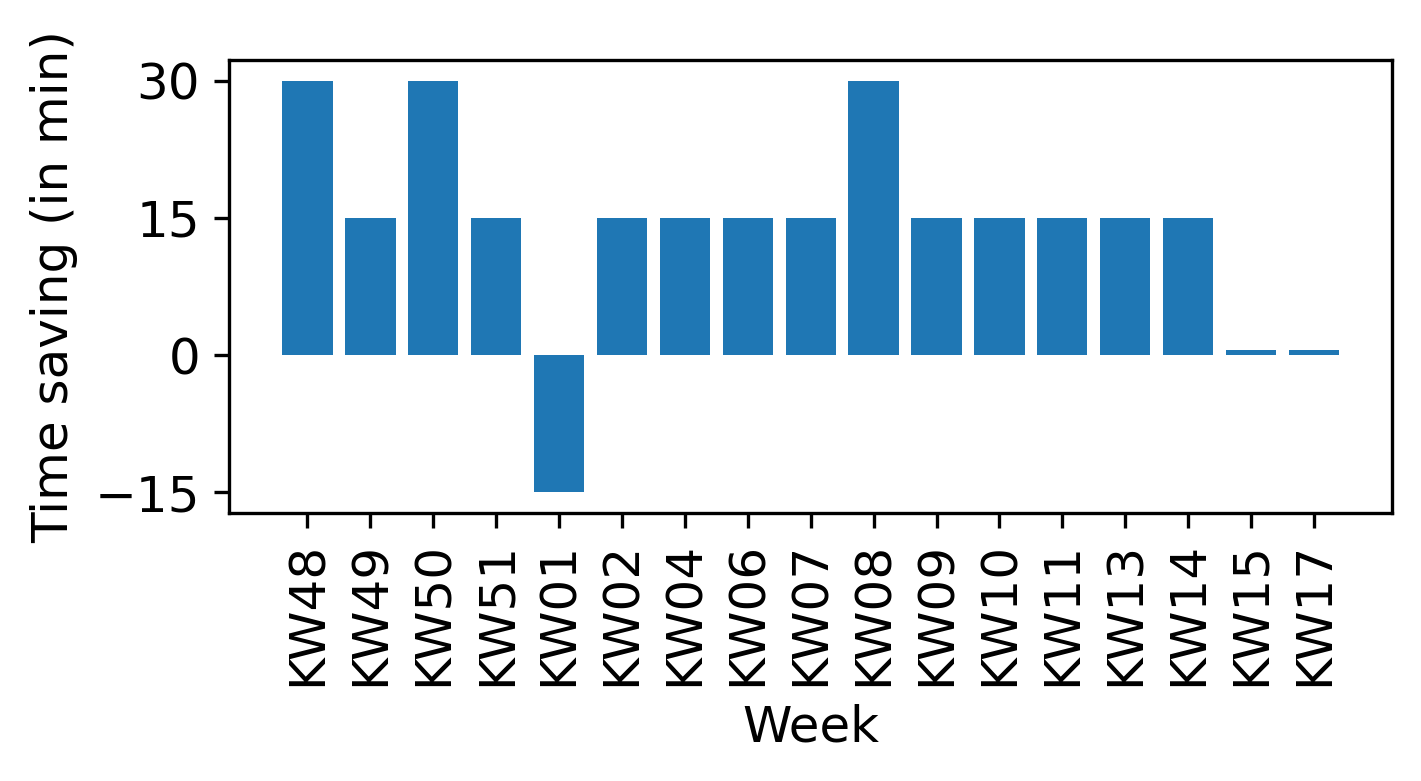

In [83]:
df_savings = pd.DataFrame([], columns=['saving'])

for week, row in df_results.iterrows():
    saving = row['IST-OCT'] - row['OPT-OCT']
    if saving == 0:
        saving = 0.5
    df_savings.loc[week] = [saving]

plt.figure(figsize=(5, 2))
plt.xlabel('Week', fontsize=12)
plt.ylabel('Time saving (in min)', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(range(-15, 31, 15), fontsize=12)
plt.bar(df_savings.index, df_savings['saving'])
plt.show()

## Comparison of the actual and computed plans for a certain week

In [44]:
week = 'KW15'

actual_order = df_results.at[week, 'actual_order']
computed_order = df_results.at[week, 'computed_order']

print('actual_order:', actual_order)
print('computed_order:', computed_order)

actual_order: ['23545', '15951', '19375', '22275', '15231', '18920', '22721', '15099', '15229', '15952', '13327', '12020', '19374', '15230', '22720', '23547']
computed_order: ['23545', '15099', '15229', '15952', '13327', '22275', '22721', '18920', '15231', '19375', '15951', '12020', '19374', '22720', '15230', '23547']


In [51]:
actual_plan = []
for product in actual_order:
    properties = df_properties.loc[product].to_list()
    df_actual_plan = actual_plans[week]
    quantity = int(df_actual_plan[df_actual_plan['Produkt'] == product]['Menge'].iloc[0]) * 1000
    actual_plan.append([product] + properties + [quantity])

df_actual = pd.DataFrame(actual_plan, columns=['Product'] + df_properties.columns.to_list() + ['Quantity']).set_index('Product')
df_actual

,Product,Name,Campaign,Volume,BottleCrate,NumShrink,NumTray,Packaging,PlannedPerformance,Quantity
0,23545,Sterilisation zu Wochenbeginn,Sterilisation_zu_Wochenbeginn,0,-,0,0,-,1,0
1,15951,Rivella Blau Tr 4x6x50 PE,Blau,50,False,4,6,Normal,18000,136000
2,19375,Rivella Blau Sc 6x125 PE HPB,Blau,125,False,1,6,HPB,13500,60000
3,22275,Rivella Blau Sc 8x150 PE,Blau,150,False,1,8,8er Pack,12500,27000
4,15231,Rivella Blau Ha 6x150 PE,Blau,150,True,1,6,Normal,11000,15000
5,18920,Riv. Blau Sc 6x150 PE Halbpalett,Blau,150,False,1,6,Halbpaletten,13500,10000
6,22721,Rivella Blau Sc 6x150 PE HPB,Blau,150,False,1,6,HPB,13500,80000
7,15099,Rivella Grüntee Sc 6x150 PE,Gruentee,150,False,1,6,Normal,13500,23000
8,15229,Rivella Grüntee Sc 6x100 PE,Gruentee,100,False,1,6,Normal,13000,11000
9,15952,Rivella Grüntee Tr 4x6x50 PE,Gruentee,50,False,4,6,Normal,18000,35000


In [53]:
computed_plan = []
for product in computed_order:
    properties = df_properties.loc[product].to_list()
    df_actual_plan = actual_plans[week]
    quantity = int(df_actual_plan[df_actual_plan['Produkt'] == product]['Menge'].iloc[0]) * 1000
    computed_plan.append([product] + properties + [quantity])

df_computed = pd.DataFrame(actual_plan, columns=['Product'] + df_properties.columns.to_list() + ['Quantity']).set_index('Product')
df_computed

,Name,Campaign,Volume,BottleCrate,NumShrink,NumTray,Packaging,PlannedPerformance,Quantity
Product,,,,,,,,,
23545,Sterilisation zu Wochenbeginn,Sterilisation_zu_Wochenbeginn,0,-,0,0,-,1,0
15951,Rivella Blau Tr 4x6x50 PE,Blau,50,False,4,6,Normal,18000,136000
19375,Rivella Blau Sc 6x125 PE HPB,Blau,125,False,1,6,HPB,13500,60000
22275,Rivella Blau Sc 8x150 PE,Blau,150,False,1,8,8er Pack,12500,27000
15231,Rivella Blau Ha 6x150 PE,Blau,150,True,1,6,Normal,11000,15000
18920,Riv. Blau Sc 6x150 PE Halbpalett,Blau,150,False,1,6,Halbpaletten,13500,10000
22721,Rivella Blau Sc 6x150 PE HPB,Blau,150,False,1,6,HPB,13500,80000
15099,Rivella Grüntee Sc 6x150 PE,Gruentee,150,False,1,6,Normal,13500,23000
15229,Rivella Grüntee Sc 6x100 PE,Gruentee,100,False,1,6,Normal,13000,11000


In [55]:
df_actual.to_csv(f'actual_{week}.csv')
df_computed.to_csv(f'computed_{week}.csv')